# Deep learning on SEM pictures

## Day 1

The objective of this project is to detect object such as nanowires, nanoholes and other objects from scanning electron microscope (SEM) pictures. My final object is to measure the length and area of a single nanowires which is a great help for my research in calculating effeicient of single nanowire solar cells. The dataset I used in this notebook are all images from my research. Lucklily I have taken tons of SEM images during work. 

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from IPython.display import display, Image
%matplotlib inline
import random
import shutil

## Import image

In [14]:
folder = "./nws/"
image_files = os.listdir(folder)
print image_files

['nw1.tiff', 'nw2.tiff', 'nw3.tiff', 'nw4.tiff', 'nw5.tiff', 'nw6.tiff']


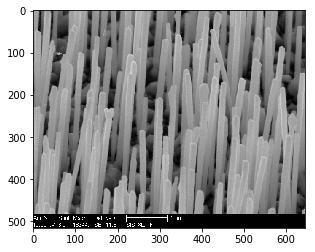

(516, 645)


In [58]:
# this is one of our nanowire image. To show the image, we need to use plt.imshow command. 
test_img = plt.imread(folder+image_files[0])
# since this is a gray scale image. There is only one channel. To show its original
# color, we need to use cmap = "gray"
#plt.figure(figsize = (20,10))
plt.imshow(test_img, cmap="gray") 
plt.show()
print (test_img.shape)

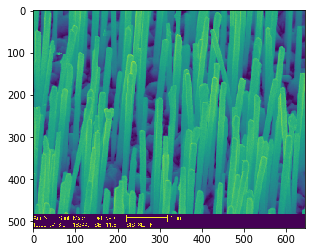

In [32]:
# if we don't use gray color, the picture will be show as below as green
plt.imshow(test_img) 
plt.show()

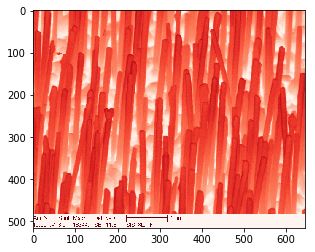

In [37]:
# we can also choose different color name, for example "Reds" will give us a redish color image.
plt.imshow(test_img, cmap = "Reds")
plt.show()

# create train and test folder

In [82]:
a = [1,2,5,3]
a.sort()
a

[1, 2, 3, 5]

In [107]:
def file_split(filenames, train_size):
    """
    Argument:
    filenames -- list of filenames
    train_size  -- ratio of train dataset (e.g. 0.8)
    Return:
    train_filenames -- list of train filenames
    test_filenames -- list of test filenames
    """
    filenames = sorted(filenames)
    random.seed(230)
    random.shuffle(filenames)
    split_1 = int(train_size * len(filenames))
    train_filenames = filenames[:split_1]
    test_filenames = filenames[split_1:]
    return train_filenames, test_filenames
    

In [108]:
filenames = os.listdir(nw_folder)
file_split(filenames, 0.5)

(['S814 2.tif', 'nw2.tiff', 'nw5.tiff'],
 ['nw3.tiff', 'nw6.tiff', 'nw1.tiff', 'nw4.tiff'])

In [110]:
# given nws and not nws, split them in to train and test dataset

nw_folder = "./nws/"
not_nw_folder = "./notnw/"
train_folder_path = "./train_folder/"
test_folder_path = "./test_folder/"

if not os.path.exists(train_folders_path) :
    os.makedirs(train_folders_path)
    os.makedirs(train_folder_path + "/nws")
    os.makedirs(train_folder_path + "/not_nws")
if not os.path.exists(test_folders_path):
    os.makedirs(test_folders_path)
    os.makedirs(test_folder_path + "/nws")
    os.makedirs(test_folder_path + "/not_nws")
    
nw_filenames = os.listdir(nw_folder)
not_nw_filenames = os.listdir(not_nw_folder)

nw_train, nw_test = file_split(nw_filenames, 0.7)


(['S814 2.tif', 'nw2.tiff', 'nw5.tiff', 'nw3.tiff'],
 ['nw6.tiff', 'nw1.tiff', 'nw4.tiff'])

## Load dataset
Now let's load the data in a more manageable format. That is to say, merge them into a single dataset of manageable size. First we convert the entire dataset into a 3Darray (image index, x, y) of floating point values, normalized to have approximately zero mean and standard devision of 0.5 to make trainig easier down the road. 

In [46]:
# import image
image_height = 516 # height of image
image_width = 645 # width of image. Will rescale to same as height in the future
pixel_depth = 255.0 
def load_image(folder):
    image_files = [folder+img for img in os.listdir(folder)] # list all the image in the folder
    dataset = np.ndarray(shape=(len(image_files), image_height, image_width),dtype = np.float32)
    num_images = 0
    for image in image_files:
        try:
            image_data = (plt.imread(image).astype(float) - pixel_depth / 2)/pixel_depth #Normalize image point
            if image_data.shape != (image_height, image_width):
               raise Exception("unexpected image shape {}".format(image_data.shape))
            dataset[num_images,:,:] = image_data # pad the image into the dataset
            num_images = num_images + 1
        except (IOError, ValueError) as e:
               print ("could not read", image_file, ":", e, '- it\'s ok, skipping.')
    dataset = dataset[0:num_images, :,:]
    return dataset

In [72]:
train_folders_path = "./train_folder/"
test_folders_path = "./test_folder/"

In [71]:
def extract(root):
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))]
    print data_folders
    return data_folders

In [74]:
train_folders = extract(train_folders_path)
test_folders = extract(test_folders_path)

['./train_folder/notnws', './train_folder/nws']
['./test_folder/notnws', './test_folder/nws']


In [76]:
# import image
image_height = 516 # height of image
image_width = 645 # width of image. Will rescale to same as height in the future
pixel_depth = 255.0

def load(data_folders,max_num_images):
    print data_folders
    dataset = np.ndarray(  # create a ndarray with (max_num_images, n_H, n_W)
        shape=(max_num_images, image_height, image_width), dtype=np.float32) 
    labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
    label_index = 0 # label index start from 0
    image_index = 0 # image_index start from 0
    for folder in data_folders:
        print folder
        print os.listdir(folder)
        for image in os.listdir(folder):
            image_file = os.path.join(folder, image)
            try:
                image_data = (plt.imread(image_file).astype(float) -
                              pixel_depth / 2) / pixel_depth # normalize image
                if image_data.shape != (image_height, image_width):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[image_index, :, :] = image_data
                labels[image_index] = label_index
                image_index += 1 # read another image
            except IOError as e:
                print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
        label_index += 1 # next folder, next label
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    labels = labels[0:num_images]
    print 'Full dataset tensor:', dataset.shape
    print 'Mean:', np.mean(dataset)
    print 'Standard deviation:', np.std(dataset)
    print 'Labels:', labels.shape
    return dataset, labels
train_dataset, train_labels = load(train_folders, 550000)
test_dataset, test_labels = load(test_folders, 20000)

['./train_folder/notnws', './train_folder/nws']
./train_folder/notnws
['S815 1.tif', 'S815 2.tif', 'S815.tif', 'S816 1.tif']
./train_folder/nws
['S815 1.tif', 'S815 2.tif', 'S815.tif', 'S816 1.tif']
Full dataset tensor: (8, 516, 645)
Mean: -0.124611
Standard deviation: 0.239604
Labels: (8,)
['./test_folder/notnws', './test_folder/nws']
./test_folder/notnws
['S814 2.tif', 'S814 3.tif', 'S814.tif', 'S815 1.tif', 'S815 2.tif']
./test_folder/nws
['S815 1.tif', 'S815 2.tif', 'S815.tif', 'S816 1.tif']
Full dataset tensor: (9, 516, 645)
Mean: -0.0801308
Standard deviation: 0.24549
Labels: (9,)


# Train and test folder

In [47]:
test_folder = load_image(folder)
print test_folder.shape

(6, 516, 645)


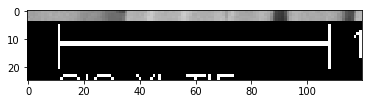

In [57]:
x1, x2, y1, y2 = (210, 330, 480, 505)
plt.imshow(test_folder[1, y1:y2, x1:x2], cmap = "gray")
plt.show()